In [17]:
# !conda install -c conda-forge librosa

# !conda install tqdm

import torch as ch
import torch.nn as nn
import torch.functional as F
import torch.utils.data as Data

import numpy as np
import pandas as pd
import scipy as sp
from matplotlib import pyplot as plt
%matplotlib inline

import os
import string
import librosa
import tqdm
import shutil
# !pip install lws
import lws
import IPython.display as ipd
from importlib import reload

import utils
reload(utils)
import hyperparams
reload(hyperparams)
import datasets
reload(datasets)
import dcttsModel
reload(dcttsModel)

<module 'dcttsModel' from '/home/aduriseti/tts/ettts_master/dcttsModel.py'>

In [18]:
dev = ch.device('cuda:0' if ch.cuda.is_available() else 'cpu')
if ch.cuda.is_available():
    ch.multiprocessing.set_start_method("spawn",force=True)

In [19]:
# params = hyperparams.Hyperparams()
ssrnParams = hyperparams.Hyperparams(sep=1,pad=None,chunk=None)
text2MelParams = hyperparams.Hyperparams(sep=0,pad=2)
ssrn = dcttsModel.SSRN(ssrnParams).to(dev)
text2Mel = dcttsModel.Text2Mel(text2MelParams).to(dev)

# print tunable hyperparams
print('TEXT2MEL HYPERPARAMS',text2MelParams.paramDict)
print('SSRN HYPERPARAMS',ssrnParams.paramDict)
[sum(np.prod(p.size()) for p in m.parameters()) for m in (text2Mel,ssrn)]


TEXT2MEL HYPERPARAMS {'sep': 0, 'alpha': 1, 'dropout': 0.05, 'norm': 2, 'lr': 0.001, 'chunk': 1, 'pad': 2, 'reversedDilation': 0}
SSRN HYPERPARAMS {'sep': 1, 'alpha': 1, 'dropout': 0.05, 'norm': 2, 'lr': 0.001, 'reversedDilation': 0}


[23949552, 24980141]

In [20]:
class DbinLoss(ch.nn.Module):
    def __init__(self):
        super(DbinLoss,self).__init__()
    
    def forward(self,Yhat,Y):
        EPS = 1e-12
        elLoss = -(Y*ch.log(Yhat+EPS)+(1-Y)*ch.log(1-Yhat+EPS))
#         return elLoss.view(elLoss.shape[0],-1).mean(1)
        return elLoss.mean()

class GAttLoss(ch.nn.Module):
    def __init__(self):
        super(GAttLoss,self).__init__()
            
    def forward(self,A,I):
        b,N,T = A.shape
        assert I.shape == (b,)
        if text2MelParams.pad == 2:
            W = ch.Tensor([[[np.e**(-(n/N-(t-i)/T)**2 / (2*text2MelParams.g**2)) 
                             for t in range(1,T+1)] 
                            for n in range(1,N+1)]
                           for i in range(b)])
        else:
            W = ch.Tensor([[np.e**(-(n/N-t/T)**2 / (2*text2MelParams.g**2)) 
                             for t in range(1,T+1)] 
                            for n in range(1,N+1)])
        W = W.to(dev)
        return ((1-W)*A).mean()



L1Fun = ch.nn.L1Loss()
BCEFun = ch.nn.BCELoss()
def SpecLossFun(Shat,S): return L1Fun(Shat,S) + BCEFun(Shat,S)
DbinFun = DbinLoss()
GAttFun = GAttLoss()

In [21]:
def text2MelLossFun(text2Mel,batch):
    bL,bS,_,bI = batch
    Shat,A = text2Mel(bL,bS)
    melLoss = SpecLossFun(Shat[:,:,:-text2Mel.params.chunk],bS[:,:,text2Mel.params.chunk:])
#     print(bI)
    attLoss = GAttFun(A,bI)
    return melLoss + attLoss

def text2MelDispFun(text2Mel,batch):
    bL,bS,bY,i = [t[0:1] for t in batch] # only use first element of batch
    print([bL.shape,bS.shape,bY.shape,i.shape])
    print('LOSS:',text2MelLossFun(text2Mel,batch).item())
    Shat,A = text2Mel(bL,bS)
    bL,bS,Shat,A,bY,i = [t[0].cpu().detach().numpy() for t in (bL,bS,Shat,A,bY,i)]
    print('PAD INDEX',i)
    print('TEXT',"".join(text2Mel.params.i2c[c] for c in bL))
    plt.imshow(bS,cmap='gray')
    plt.show()
    plt.imshow(Shat,cmap='gray')
    plt.show()
    plt.imshow(A,cmap='gray')
    plt.show()

In [22]:
text2MelParams = hyperparams.Hyperparams(sep=0,pad=0,reversedDilation=1)
# nWorkers = 8 if ch.cuda.is_available() else 0
nWorkers = 6 if ch.cuda.is_available() else 0
text2MelLoader = Data.DataLoader(datasets.LJSpeechDataset(ttmel=1,params=text2MelParams),
                                 batch_size=16,
                                 shuffle=True,
                                 num_workers=nWorkers)
text2Mel = dcttsModel.Text2Mel(text2MelParams).to(dev)
text2MelOpt = ch.optim.Adam(text2Mel.parameters(),lr=text2MelParams.lr,
                            betas=(text2MelParams.b1,text2MelParams.b2),
                            eps=text2MelParams.eps)
text2MelWrapper = utils.ModelWrapper(network=text2Mel,optimizer=text2MelOpt,
                                     lossFun=text2MelLossFun,loader=text2MelLoader,
                                     modelName='text2Mel',dev=dev,dispFun=text2MelDispFun)

INITIALIZED text2Mel WITH HYPERPARAMS {'sep': 0, 'alpha': 1, 'dropout': 0.05, 'norm': 2, 'lr': 0.001, 'chunk': 1, 'pad': 0, 'reversedDilation': 1}
TOTAL PARAM COUNT 23949552


In [23]:
text2MelWrapper.load()

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:1
LOADED EPOCH 100, LOSS 0.024730781621452588, BEST LOSS 0.024730781621452588 FROM ./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:1/text2MelLast.99c9668d979059d0a6e850779be1e9b25f8c4f5d73206e6d155ee84af7de552e.chkpt.tar


EPOCH 100


epoch 100 total 0.02471728307653719
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.02284783124923706
PAD INDEX 0
TEXT it must have been an imposing sight to one standing without to have seen the walls, one after another,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


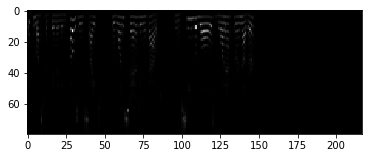

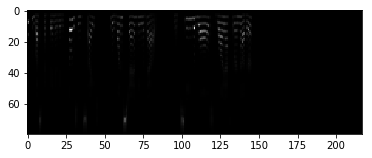

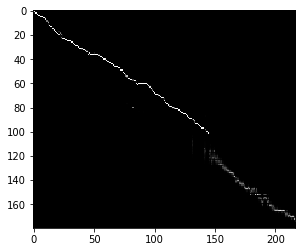

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:1
SAVED EPOCH 101, LOSS 0.02471728307653719, BEST LOSS 0.02471728307653719 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:1/text2MelLast.99c9668d979059d0a6e850779be1e9b25f8c4f5d73206e6d155ee84af7de552e.chkpt.tar', './text2MelLast.99c9668d979059d0a6e850779be1e9b25f8c4f5d73206e6d155ee84af7de552e.chkpt.tar', './sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:1/text2MelBest.99c9668d979059d0a6e850779be1e9b25f8c4f5d73206e6d155ee84af7de552e.chkpt.tar', './text2MelBest.99c9668d979059d0a6e850779be1e9b25f8c4f5d73206e6d155ee84af7de552e.chkpt.tar']
EPOCH 101


epoch 101 total 0.024723197255672805
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.03238710016012192
PAD INDEX 0
TEXT who constantly breathed an air heavy, and, when the wards were first opened in the morning, particularly offensive.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


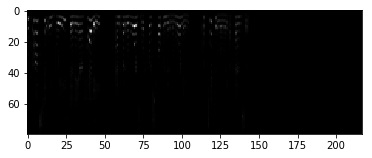

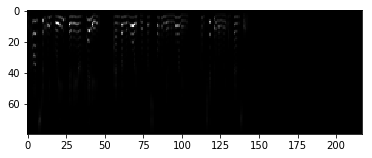

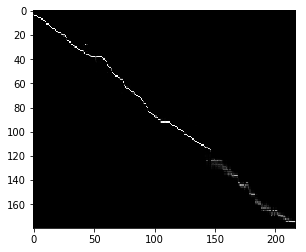

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:1
SAVED EPOCH 102, LOSS 0.024723197255672805, BEST LOSS 0.02471728307653719 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:1/text2MelLast.99c9668d979059d0a6e850779be1e9b25f8c4f5d73206e6d155ee84af7de552e.chkpt.tar', './text2MelLast.99c9668d979059d0a6e850779be1e9b25f8c4f5d73206e6d155ee84af7de552e.chkpt.tar']
EPOCH 102


epoch 102 total 0.02469247566786275
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.018751217052340508
PAD INDEX 0
TEXT the trade of fence, or receiver, therefore, is very nearly as old as the crimes which it so obviously fostered.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


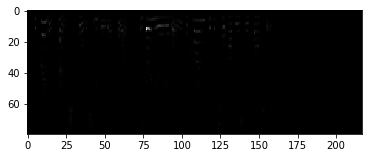

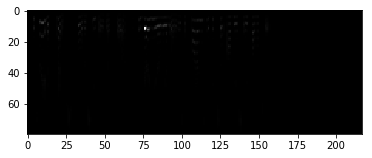

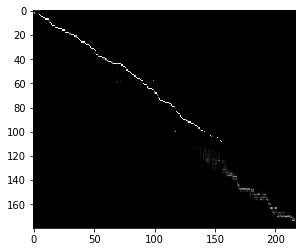

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:1
SAVED EPOCH 103, LOSS 0.02469247566786275, BEST LOSS 0.02469247566786275 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:1/text2MelLast.99c9668d979059d0a6e850779be1e9b25f8c4f5d73206e6d155ee84af7de552e.chkpt.tar', './text2MelLast.99c9668d979059d0a6e850779be1e9b25f8c4f5d73206e6d155ee84af7de552e.chkpt.tar', './sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:1/text2MelBest.99c9668d979059d0a6e850779be1e9b25f8c4f5d73206e6d155ee84af7de552e.chkpt.tar', './text2MelBest.99c9668d979059d0a6e850779be1e9b25f8c4f5d73206e6d155ee84af7de552e.chkpt.tar']
EPOCH 103


epoch 103 total 0.024687235279759363
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.020963015034794807
PAD INDEX 0
TEXT introduced into their assembly, he began to bewail his misfortunes, telling them thatNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


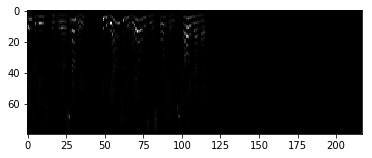

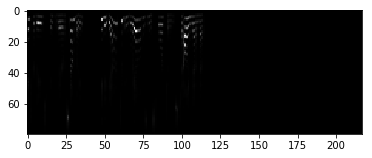

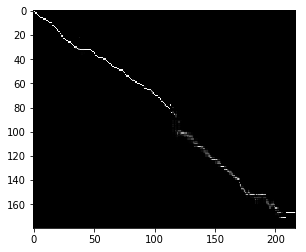

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:1
SAVED EPOCH 104, LOSS 0.024687235279759363, BEST LOSS 0.024687235279759363 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:1/text2MelLast.99c9668d979059d0a6e850779be1e9b25f8c4f5d73206e6d155ee84af7de552e.chkpt.tar', './text2MelLast.99c9668d979059d0a6e850779be1e9b25f8c4f5d73206e6d155ee84af7de552e.chkpt.tar', './sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:1/text2MelBest.99c9668d979059d0a6e850779be1e9b25f8c4f5d73206e6d155ee84af7de552e.chkpt.tar', './text2MelBest.99c9668d979059d0a6e850779be1e9b25f8c4f5d73206e6d155ee84af7de552e.chkpt.tar']
EPOCH 104


epoch 104 total 0.02468673552650569
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.0294018667191267
PAD INDEX 0
TEXT the bag found on the sixth floor was eighty-eight inches long.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


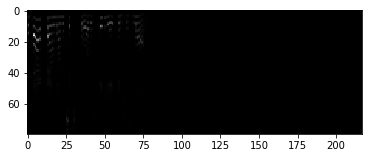

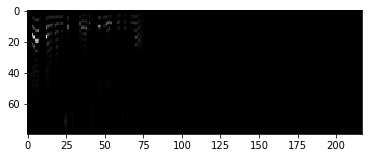

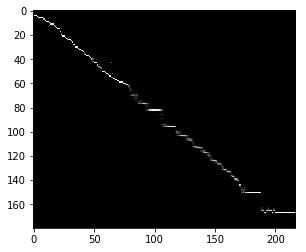

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:1
SAVED EPOCH 105, LOSS 0.02468673552650569, BEST LOSS 0.02468673552650569 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:1/text2MelLast.99c9668d979059d0a6e850779be1e9b25f8c4f5d73206e6d155ee84af7de552e.chkpt.tar', './text2MelLast.99c9668d979059d0a6e850779be1e9b25f8c4f5d73206e6d155ee84af7de552e.chkpt.tar', './sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:1/text2MelBest.99c9668d979059d0a6e850779be1e9b25f8c4f5d73206e6d155ee84af7de552e.chkpt.tar', './text2MelBest.99c9668d979059d0a6e850779be1e9b25f8c4f5d73206e6d155ee84af7de552e.chkpt.tar']
EPOCH 105


epoch 105 total 0.02467840721469317
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.028354275971651077
PAD INDEX 0
TEXT some rooms remained quite empty and unoccupied, while others were full to overflowing.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


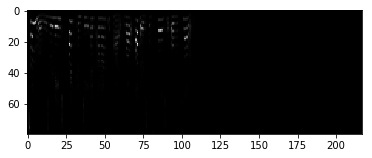

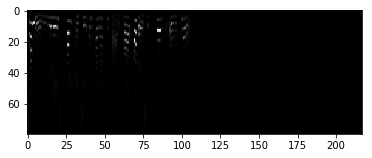

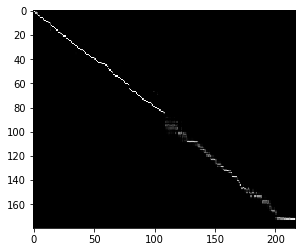

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:1
SAVED EPOCH 106, LOSS 0.02467840721469317, BEST LOSS 0.02467840721469317 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:1/text2MelLast.99c9668d979059d0a6e850779be1e9b25f8c4f5d73206e6d155ee84af7de552e.chkpt.tar', './text2MelLast.99c9668d979059d0a6e850779be1e9b25f8c4f5d73206e6d155ee84af7de552e.chkpt.tar', './sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:1/text2MelBest.99c9668d979059d0a6e850779be1e9b25f8c4f5d73206e6d155ee84af7de552e.chkpt.tar', './text2MelBest.99c9668d979059d0a6e850779be1e9b25f8c4f5d73206e6d155ee84af7de552e.chkpt.tar']
EPOCH 106


epoch 106 total 0.0246802519756689
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.03733109310269356
PAD INDEX 0
TEXT trisect the plaza, converging at the apex of the triangle to form a triple underpass beneath a multiple railroad bridgeNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


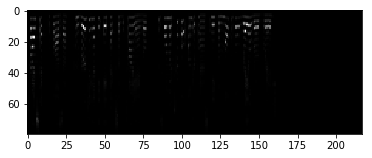

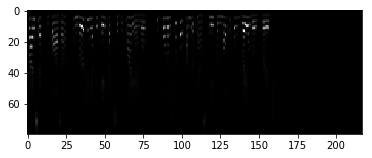

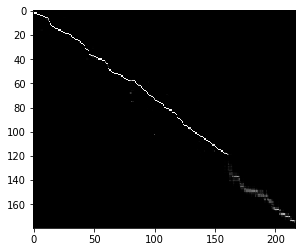

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:1
SAVED EPOCH 107, LOSS 0.0246802519756689, BEST LOSS 0.02467840721469317 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:1/text2MelLast.99c9668d979059d0a6e850779be1e9b25f8c4f5d73206e6d155ee84af7de552e.chkpt.tar', './text2MelLast.99c9668d979059d0a6e850779be1e9b25f8c4f5d73206e6d155ee84af7de552e.chkpt.tar']
EPOCH 107


epoch 107 total 0.02466227907909831
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.027886688709259033
PAD INDEX 0
TEXT at halifax forrester learnt that the men he wanted had gone on to boston, thence to buffalo and canada, and back to boston.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


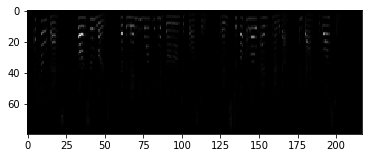

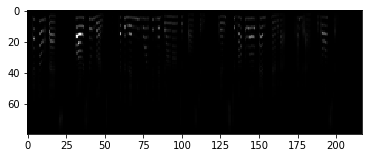

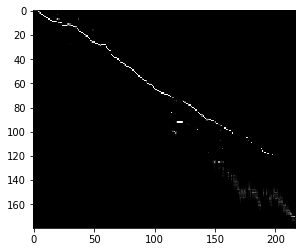

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:1
SAVED EPOCH 108, LOSS 0.02466227907909831, BEST LOSS 0.02466227907909831 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:1/text2MelLast.99c9668d979059d0a6e850779be1e9b25f8c4f5d73206e6d155ee84af7de552e.chkpt.tar', './text2MelLast.99c9668d979059d0a6e850779be1e9b25f8c4f5d73206e6d155ee84af7de552e.chkpt.tar', './sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:1/text2MelBest.99c9668d979059d0a6e850779be1e9b25f8c4f5d73206e6d155ee84af7de552e.chkpt.tar', './text2MelBest.99c9668d979059d0a6e850779be1e9b25f8c4f5d73206e6d155ee84af7de552e.chkpt.tar']
EPOCH 108


epoch 108 total 0.02466302492669714
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.03468846529722214
PAD INDEX 0
TEXT while the criminals stand upon it, by two pieces of timber, which are made to slide in and out of the prison wall through apertures made for that purpose.NNNNNNNNNNNNNNNNNNNNNNNNNN


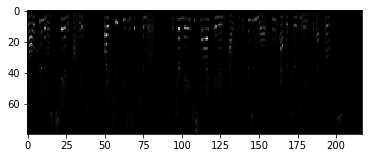

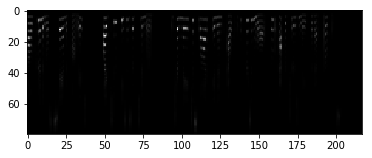

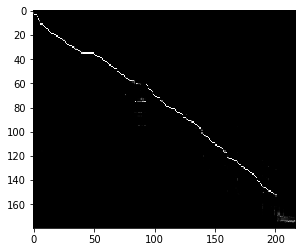

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:1
SAVED EPOCH 109, LOSS 0.02466302492669714, BEST LOSS 0.02466227907909831 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:1/text2MelLast.99c9668d979059d0a6e850779be1e9b25f8c4f5d73206e6d155ee84af7de552e.chkpt.tar', './text2MelLast.99c9668d979059d0a6e850779be1e9b25f8c4f5d73206e6d155ee84af7de552e.chkpt.tar']
EPOCH 109


epoch 109 total 0.024645734570030844
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.028699755668640137
PAD INDEX 0
TEXT he apparently based his claim for a visa in transit to russiaNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


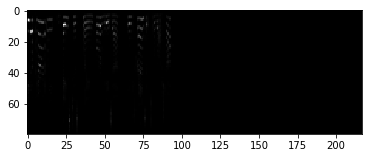

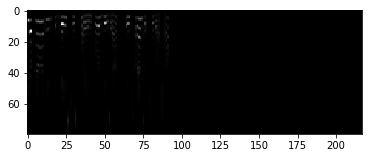

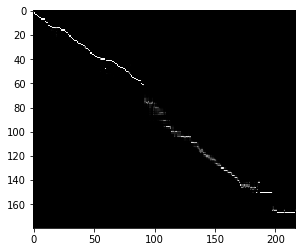

HYPERPARAMS sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:1
SAVED EPOCH 110, LOSS 0.024645734570030844, BEST LOSS 0.024645734570030844 TO ['./sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:1/text2MelLast.99c9668d979059d0a6e850779be1e9b25f8c4f5d73206e6d155ee84af7de552e.chkpt.tar', './text2MelLast.99c9668d979059d0a6e850779be1e9b25f8c4f5d73206e6d155ee84af7de552e.chkpt.tar', './sep:0|alpha:1|dropout:0.05|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:1/text2MelBest.99c9668d979059d0a6e850779be1e9b25f8c4f5d73206e6d155ee84af7de552e.chkpt.tar', './text2MelBest.99c9668d979059d0a6e850779be1e9b25f8c4f5d73206e6d155ee84af7de552e.chkpt.tar']
EPOCH 110


In [ ]:
text2MelWrapper.train(numEpochs=100)

In [ ]:
text2MelWrapper.load()
plt.plot(text2MelWrapper.lossHist[5:])

In [ ]:
def ssrnLossFun(ssrn,batch):
    _,bS,bY,_ = batch
    Yhat = ssrn(bS)
    return SpecLossFun(Yhat,bY)

def ssrnDispFun(ssrn,batch):
    bL,bS,bY,i = [t[0:1] for t in batch] # only use first element of batch
#     print([t.device for t in batch])
    print('LOSS:',ssrnLossFun(ssrn,batch).item())
    print(bS.shape)
    Yhat = ssrn(bS)
    bL,bS,bY,Yhat,i = [t[0].cpu().detach().numpy() for t in (bL,bS,bY,Yhat,i)]
    print('PAD INDEX',i)
    print('TEXT',"".join(ssrn.params.i2c[c] for c in bL))
    plt.imshow(bS,cmap='gray')
    plt.show()
    plt.imshow(bY,cmap='gray')
    plt.show()
    plt.imshow(Yhat,cmap='gray')
    plt.show()

In [ ]:
ssrnParams = hyperparams.Hyperparams(sep=0)
# nWorkers = 8 if ch.cuda.is_available() else 0
nWorkers = 6 if ch.cuda.is_available() else 0
ssrnLoader = Data.DataLoader(datasets.LJSpeechDataset(ttmel=0),
                             batch_size=16,
                             shuffle=True,
                             num_workers=nWorkers)
ssrn = dcttsModel.SSRN(ssrnParams).to(dev)
ssrnOpt = ch.optim.Adam(ssrn.parameters(),lr=ssrnParams.lr,
                        betas=(ssrnParams.b1,ssrnParams.b2),
                        eps=ssrnParams.eps)
ssrnWrapper = utils.ModelWrapper(network=ssrn,optimizer=ssrnOpt,
                                 lossFun=ssrnLossFun,loader=ssrnLoader,
                                 modelName='ssrn',dev=dev,dispFun=ssrnDispFun)

In [ ]:
ssrnWrapper.load()

In [ ]:
ssrnWrapper.train(numEpochs=50)